# GP regression with GPyTorch

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gpytorch import GPyTorchModel

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 0.2, 2)
# train_x = torch.ndarray([0, 0.2])
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

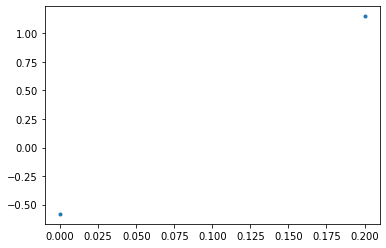

In [3]:
plt.plot(train_x, train_y, '.')

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(GPyTorchModel, gpytorch.models.ExactGP):
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        # super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x.reshape(-1), train_y.reshape(-1), likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module.lengthscale = 0.4
        self.to(train_x)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0,1e-14))
model = ExactGPModel(train_x, train_y, likelihood)

/Users/abauville/opt/anaconda3/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
/Users/abauville/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


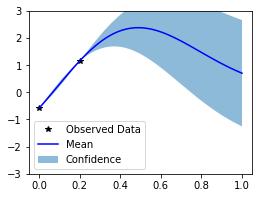

In [5]:
model.eval()
likelihood.eval()
f, ax = plt.subplots(1, 1, figsize=(4, 3))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 101)
    observed_pred = likelihood(model(test_x))
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [7]:
test_x = torch.linspace(0,1,50)
EI = ExpectedImprovement(model, best_f=0.2)
ei = EI(test_x.reshape(-1,1,1))

/Users/abauville/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


/Users/abauville/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


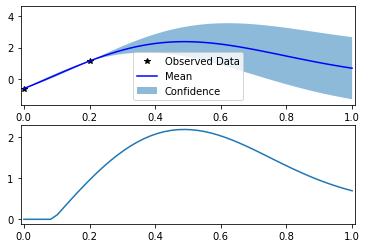

In [41]:
model.eval()
likelihood.eval()
with torch.no_grad():
    ax = plt.subplot(2,1,1)
    observed_pred = likelihood(model(test_x))
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([lower.min() - lower.min().abs()*0.3, upper.max() + upper.max().abs()*0.3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.xlim(-0.01,1.01)
    plt.subplot(2,1,2)
    plt.plot(test_x, ei)
    plt.xlim(-0.01,1.01)

In [26]:
upper

tensor([-0.5804, -0.3783, -0.1765,  0.0214,  0.2138,  0.3993,  0.5764,  0.7438,
         0.9004,  1.0448,  1.1906,  1.3878,  1.5826,  1.7737,  1.9596,  2.1391,
         2.3110,  2.4741,  2.6274,  2.7702,  2.9016,  3.0212,  3.1285,  3.2232,
         3.3052,  3.3745,  3.4311,  3.4754,  3.5077,  3.5285,  3.5383,  3.5378,
         3.5277,  3.5088,  3.4818,  3.4477,  3.4072,  3.3613,  3.3106,  3.2562,
         3.1988,  3.1392,  3.0780,  3.0159,  2.9537,  2.8918,  2.8307,  2.7709,
         2.7128,  2.6567])

tensor([[0.0000],
        [0.0204],
        [0.0408],
        [0.0612],
        [0.0816],
        [0.1020],
        [0.1224],
        [0.1429],
        [0.1633],
        [0.1837],
        [0.2041],
        [0.2245],
        [0.2449],
        [0.2653],
        [0.2857],
        [0.3061],
        [0.3265],
        [0.3469],
        [0.3673],
        [0.3878],
        [0.4082],
        [0.4286],
        [0.4490],
        [0.4694],
        [0.4898],
        [0.5102],
        [0.5306],
        [0.5510],
        [0.5714],
        [0.5918],
        [0.6122],
        [0.6327],
        [0.6531],
        [0.6735],
        [0.6939],
        [0.7143],
        [0.7347],
        [0.7551],
        [0.7755],
        [0.7959],
        [0.8163],
        [0.8367],
        [0.8571],
        [0.8776],
        [0.8980],
        [0.9184],
        [0.9388],
        [0.9592],
        [0.9796],
        [1.0000]])